# Use Case - Churn Prediction

> Data Mining for Business Analytics ADS-505
>
> Fatemeh Khosravi - Stephen Kuc - Ruddy Simonpour

In [38]:
# import dependencies
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pylab as plt
import seaborn as sns

import statsmodels.tools.tools as stattools

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [18]:
os.chdir("/Users/ruddysimonpour/Desktop/ADS505-Applied Data Sci for Business/Project-ADS505/ADS505-Finall-project/Dataset")

In [19]:
bank = pd.read_csv("Bank Customer Churn Prediction.csv",low_memory=False)

In [20]:
# print data
bank.sample(10)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
4440,15760121,712,France,Male,32,9,100606.02,1,1,0,165693.06,0
9924,15578865,632,Germany,Female,50,5,107959.39,1,1,1,6985.34,1
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
4394,15669175,479,Germany,Male,24,6,107637.97,2,0,1,169505.83,0
6360,15661591,413,Germany,Male,39,1,130969.77,2,1,1,158891.79,0
4544,15758081,673,Spain,Male,39,8,138160.00,1,1,1,110468.51,0
2507,15628007,653,France,Male,33,1,0.00,2,0,0,53379.52,0
6586,15699515,643,Germany,Male,33,7,98630.31,2,1,1,40250.82,0
8318,15765402,520,France,Female,39,6,145644.05,1,0,0,104118.93,0
9785,15609187,455,France,Female,27,5,155879.09,2,0,0,70774.97,0


In [21]:
# checking the data types
bank.dtypes

customer_id           int64
credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [22]:
# dataframe shape
print(f'Number of rows in the dataframe {bank.shape[0]}')
print(f'Number of columns in the dataframe {bank.shape[1]}')

Number of rows in the dataframe 10000
Number of columns in the dataframe 12


In [23]:
bank.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
credit_score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
products_number,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
credit_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
active_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
churn,10000.0,2.037000e-01,0.402769,0.00,0.00,0.000000e+00,0.000000e+00,1.00


For binary variables, incl target:

Churn: ~20.4% positive records CC: ~70.5% positive active member: ~51.5% positive

For numerical:

cc: seems about symmetrical (median ~= mean); ranges from 350 - 850

age: 18 - 92; slightly skewed right, with mean of 38.9 and median of 37.

tenure: seems symmetrical; anywhere from 0 years to 10 years.

balance: ranges from  0𝑡𝑜 250k. The median > mean (~97k vs 76k), so it is skewed left

estimated salary: mean / median both around 100k. ranges from 57.5k to ~200k.

In [24]:
# checking for missing values
bank.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

There is no missing values in the dataset

In [25]:
# checking for duplicated values
duplicate_values = bank.duplicated().sum()
print(f'The number of duplicated values are : {duplicate_values}')

The number of duplicated values are : 0


In [26]:
# check number of unique values for each column
bank.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

There are only 3 different countries and 4 different products. These two we can make into dummy variables. CC and active member are indeed binary. 

### Visualization

<AxesSubplot:>

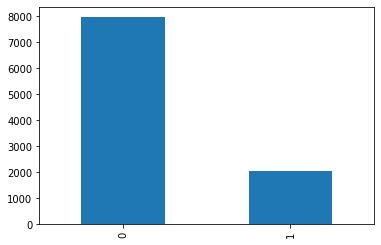

In [60]:
bank["churn"].value_counts().plot(kind="bar")

In [61]:
# The target variable is not balance

#### Under-sampling

In [73]:
df_class0_under = class0_df.sample(class_count1)

df_test_under = pd.concat([df_class0_under, class1_df], axis = 0)

print(f'Random Under Sampling')
print(df_test_under.churn.value_counts())

Random Under Sampling
0    2037
1    2037
Name: churn, dtype: int64


## Data Cleaning

There is not missing values and duplicated values in the dataset. Now we can drop unnecessary columns. "Customer-ID"s are assigned at random and are not based on anything. Therefore, we can remove this column

In [28]:
bank_country = pd.get_dummies(bank['country'], prefix = 'country', drop_first = True)
bank_product = pd.get_dummies(bank['products_number'], prefix = 'prod', drop_first = True)
bank_gender= pd.get_dummies(bank['gender'], prefix = 'gender', drop_first = True)

churn_df = bank.drop(['country', 'products_number', 'gender', 'customer_id'], axis = 1)

churn_df = pd.concat([churn_df, bank_country, bank_gender, bank_product], axis = 1)

churn_df.head()

,credit_score,age,tenure,balance,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male,prod_2,prod_3,prod_4
0,619,42,2,0.00,1,1,101348.88,1,0,0,0,0,0,0
1,608,41,1,83807.86,0,1,112542.58,0,0,1,0,0,0,0
2,502,42,8,159660.80,1,0,113931.57,1,0,0,0,0,1,0
3,699,39,1,0.00,0,0,93826.63,0,0,0,0,1,0,0
4,850,43,2,125510.82,1,1,79084.10,0,0,1,0,0,0,0


In [29]:
# change the data type of the dummy variables (uint8 --> int64)
def data_type_change(df,cols):
    df[cols]=df[cols].astype(int)
    return df

churn_df = data_type_change(churn_df,["country_Germany","country_Spain",
                                      "gender_Male", "prod_2", "prod_3", "prod_4"])

churn_df.dtypes

credit_score          int64
age                   int64
tenure                int64
balance             float64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
country_Germany       int64
country_Spain         int64
gender_Male           int64
prod_2                int64
prod_3                int64
prod_4                int64
dtype: object

### Checking outliers

/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


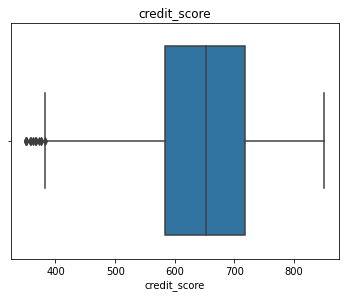

/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


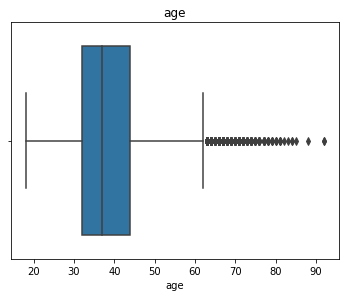

/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


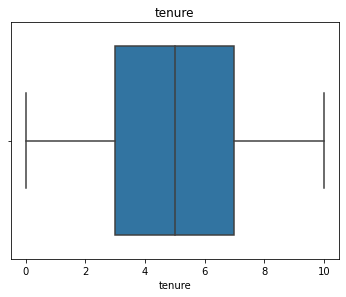

/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


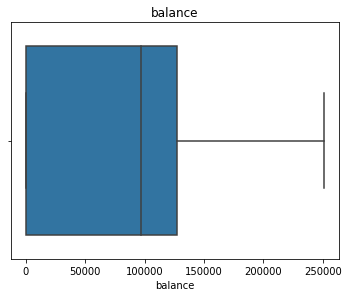

/Users/ruddysimonpour/opt/anaconda3/envs/pythonenv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


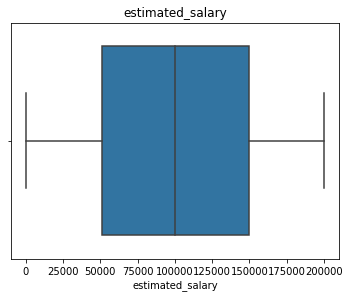

In [33]:
col=bank[['credit_score','age','tenure','balance','estimated_salary']] 
for i in col:
  n=1
  plt.figure(figsize=(20,20))
  plt.subplot(4,3,1)
  sns.boxplot(bank[i])
  plt.title(i)
  plt.show()
  n=n+1

It seems outliers represent their natural variations in the population, no need to remove them from the dataset.

<AxesSubplot:>

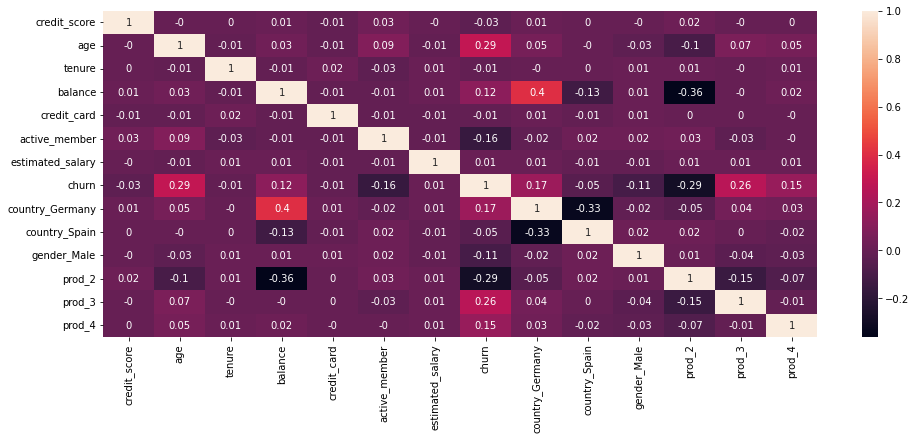

In [32]:
# Correlation matrix
plt.figure(figsize=(16, 6))
sns.heatmap(round(churn_df.corr(),2), annot = True)

highest correlations with churn: age (+.29), product 2 (-.29), product 3 (+.26), country_germany (+.17)

Multi collinearities?

Age -- no, next highest correlation is .09 with active member.

prod_2 -- yes, -.36 with balance; -.15 with prod_3

prod_3 -- not really, except -.15 with prod_2

country_Germany -- .4 with balance; -.33 with country_Spain

In [34]:
# for scaling any numerical 

churn_numerical = churn_df[['credit_score','age', 'tenure','balance', 'estimated_salary']]


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(churn_numerical)

churn_numerical_scaled = scaler.transform(churn_numerical)

churn_numerical_scaled = pd.DataFrame(churn_numerical_scaled, columns = churn_numerical.columns)

churn_numerical_scaled.head()

,credit_score,age,tenure,balance,estimated_salary
0,-0.326221,0.293517,-1.041760,-1.225848,0.021886
1,-0.440036,0.198164,-1.387538,0.117350,0.216534
2,-1.536794,0.293517,1.032908,1.333053,0.240687
3,0.501521,0.007457,-1.387538,-1.225848,-0.108918
4,2.063884,0.388871,-1.041760,0.785728,-0.365276


In [36]:
# We can add these back into the

churn_df_scaled = churn_df.drop(churn_numerical, axis =1)

churn_df_scaled = pd.concat([churn_df_scaled, churn_numerical_scaled], axis = 1)

churn_df_scaled.head(5)

,credit_card,active_member,churn,country_Germany,country_Spain,gender_Male,prod_2,prod_3,prod_4,credit_score,age,tenure,balance,estimated_salary
0,1,1,1,0,0,0,0,0,0,-0.326221,0.293517,-1.041760,-1.225848,0.021886
1,0,1,0,0,1,0,0,0,0,-0.440036,0.198164,-1.387538,0.117350,0.216534
2,1,0,1,0,0,0,0,1,0,-1.536794,0.293517,1.032908,1.333053,0.240687
3,0,0,0,0,0,0,1,0,0,0.501521,0.007457,-1.387538,-1.225848,-0.108918
4,1,1,0,0,1,0,0,0,0,2.063884,0.388871,-1.041760,0.785728,-0.365276


## Building Model

#### Imbalance dataset

In [75]:
class_count0, class_count1 = churn_df.churn.value_counts()


class0_df = churn_df[churn_df["churn"]==0]
class1_df = churn_df[churn_df["churn"]==1]

#### Method1: Under-Sampling

In [76]:
df_class0_under = class0_df.sample(class_count1)

df_test_under = pd.concat([df_class0_under, class1_df], axis = 0)

print(f'Random Under Sampling')
print(df_test_under.churn.value_counts())

Random Under Sampling
0    2037
1    2037
Name: churn, dtype: int64


#### Method2: Over-Sampling

In [39]:
# splitting into X and Y

X = churn_df.drop('churn', axis = 1)
y = churn_df['churn']

# partitioning data into 90% train and 10% test, and then will further split for validation

trainX, testX, trainy, testy = train_test_split(X, y, test_size = .1, random_state = 12345)

# using 80 / 20 split for train and validation set

trainX, validX, trainy, validy = train_test_split(trainX, trainy, test_size = .2, random_state = 12345)

In [40]:
print("Test set dimensions: ", testX.shape, 
      "\n Train set dimensions: ", trainX.shape,
      "\n Validation set dimension: ", validX.shape)

Test set dimensions:  (1000, 13) 
 Train set dimensions:  (7200, 13) 
 Validation set dimension:  (1800, 13)


### K-NN

In [42]:
# Train a classifier for different values of k
knn_results = []
for k in range(1, 25, 2):
    knn = KNeighborsClassifier(n_neighbors=k).fit(trainX, trainy)
    knn_results.append({
        'k': k,
        'accuracy': accuracy_score(validy, knn.predict(validX)),
        'precision': precision_score(validy, knn.predict(validX)),
        'f1_score': f1_score(validy, knn.predict(validX))
    })

# Convert results to a pandas data frame
knn_results = pd.DataFrame(knn_results)
knn_results

,k,accuracy,precision,f1_score
0,1,0.677778,0.226131,0.236842
1,3,0.746667,0.265000,0.188612
2,5,0.770556,0.296000,0.151951
3,7,0.775556,0.266667,0.106195
4,9,0.785000,0.272727,0.071942
5,11,0.789444,0.270270,0.050125
6,13,0.795000,0.360000,0.046512
7,15,0.798333,0.461538,0.032000
8,17,0.797222,0.200000,0.005450
9,19,0.798889,0.500000,0.005495


Text(0, 0.5, 'Metrics score')

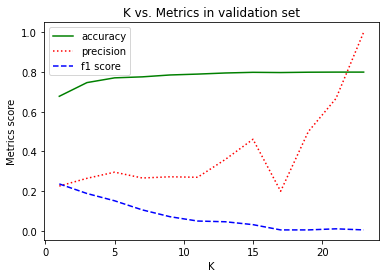

In [43]:
# Plotting K-nn metrics from validation tests

# show accuracy by k
plt.plot(knn_results.k, knn_results.accuracy, linestyle='-', c='green', label = "accuracy")
plt.plot(knn_results.k, knn_results.precision, linestyle=':', c='red', label = "precision")
plt.plot(knn_results.k, knn_results['f1_score'], linestyle='--', c='blue', label = "f1 score")
plt.legend()
plt.title('K vs. Metrics in validation set')
plt.xlabel('K')
plt.ylabel('Metrics score')

In [55]:
# Prediction using Test dataset
predictions = knn.predict(validX)
probabilities = knn.predict_proba(validX)

knn_result = pd.DataFrame({'actual': validy, 
                             'p(0)': [p[0] for p in probabilities],
                             'p(1)': [p[1] for p in probabilities],
                             'predicted': predictions})

fundfuture_df_donor = knn_result.loc[knn_result.predicted == 1]
fundfuture_df_donor

,actual,p(0),p(1),predicted
2340,1,0.478261,0.521739,1
